

# Project: Effects of Federal Funds Rate on Inflation and Unemployment
### DATA608
### Farhod Ibragimov

This project investigates how changes in the Federal Funds Rate (Fed Funds) affect two key economic outcomes:
- **Inflation** (measured using Core PCE YoY % change)
- **Unemployment** (U.S. unemployment rate)

In this project we examine both **hikes** and **cuts**, compare their effects on inflation and unemployment, and highlight the lagged (it takes several months) responses.  
The study covers the last 25 years of U.S. data from the Federal Reserve Economic Data (FRED) https://fred.stlouisfed.org/ .

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from fredapi import Fred

### Data Loading

We load three datasets from FRED using API:
- **FEDFUNDS** – Federal Funds Effective Rate
- **UNRATE** – Unemployment Rate
- **Core PCE** – Personal Consumption Expenditures (proxy for inflation)

All series are monthly and resampled to end-of-month values for consistency.


In [2]:

fred = Fred(api_key="529e9e98ac3e48bcd90a322faa2ffeca")

# FRED series
series_ids = {
    "FedFunds": "FEDFUNDS",    
    "Unemployment": "UNRATE",  
    "PCE": "PCE"               
}

# download series and align into one DF
df = pd.DataFrame()
for name, sid in series_ids.items():
    df[name] = fred.get_series(sid)

df.index = pd.to_datetime(df.index)
df = df.resample("ME").last()
df.head()



plt.rcParams.update({
    "font.family": "DejaVu Sans",   
    "font.size": 12,                
    "axes.titlesize": 14,           
    "axes.labelsize": 12,           
    "xtick.labelsize": 10,          
    "ytick.labelsize": 10,          
    "legend.fontsize": 11,         
})


### Data Preparation

- Compute **Inflation YoY (%)** = % change in PCE over 12 months.
- Apply a **3-month rolling average** to smooth volatility.
- Restrict dataset to the **last 25 years** to focus on recent monetary policy cycles.


In [3]:
# last 25 years
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=25)
df = df.loc[(df.index >= start) & (df.index <= end)]

# inflation
df["Inflation YoY (%)"] = df["PCE"].pct_change(12) * 100

# set labels
df = df.rename(columns={
    "FedFunds":"Fed Funds Rate (%)",
    "Unemployment":"Unemployment Rate (%)",
})

ff  = "Fed Funds Rate (%)"
inf = "Inflation YoY (%)"
ur  = "Unemployment Rate (%)"

smooth = df[[ff, inf, ur]].rolling(window=3, center=True).mean()
X = smooth.index

C:\Users\farho\AppData\Local\Temp\ipykernel_14052\1655973019.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Inflation YoY (%)"] = df["PCE"].pct_change(12) * 100


### Event Detection

We identify periods of sustained **rate hikes** and **rate cuts**.  
Two approaches are used:
1. **Automatic detection** – looks for runs of ≥3 consecutive increases or decreases.
2. **Manual windows** – defined based on well-known Fed cycles (e.g., post-2004 hikes, post-COVID hikes).  

We use **manual windows** in the final analysis to align better with economic history.


In [4]:
# automatic detection
def detect_runs(rate, min_run_len=3):
    """
    detecting continuous hikes and cuts as contiguous runs.
    
    """
    r = rate.copy()
    dm = r.diff()
    dates = r.index.to_list()
    hikes, cuts = [], []
    i, n = 1, len(r)
    while i < n:
        if np.isnan(dm[i]) or dm[i] == 0:
            i += 1; continue
        sign = np.sign(dm[i])
        start_i = i
        run_len = 1
        i += 1
        while i < n and np.sign(dm[i]) == sign and not np.isnan(dm[i]):
            run_len += 1; i += 1
        if run_len >= min_run_len:
            start_date, end_date = dates[start_i], dates[i-1]
            if sign > 0:
                hikes.append((start_date, end_date))
            else:
                cuts.append((start_date, end_date))
    return hikes, cuts

auto_hike_periods, auto_cut_periods = detect_runs(df[ff], 3)

C:\Users\farho\AppData\Local\Temp\ipykernel_14052\352586927.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(dm[i]) or dm[i] == 0:
C:\Users\farho\AppData\Local\Temp\ipykernel_14052\352586927.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sign = np.sign(dm[i])
C:\Users\farho\AppData\Local\Temp\ipykernel_14052\352586927.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i < n and np.sign(dm[i]) == sign an

In [5]:
# manual selected ranges
manual_hike_periods = [
    (pd.Timestamp("2004-02-01"), pd.Timestamp("2007-03-01")),
    (pd.Timestamp("2015-12-01"), pd.Timestamp("2019-05-01")),
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2023-11-01")),
]
manual_cut_periods = [
    (pd.Timestamp("2000-09-01"), pd.Timestamp("2003-09-01")),
    (pd.Timestamp("2007-06-01"), pd.Timestamp("2009-01-01")),
    (pd.Timestamp("2019-06-01"), pd.Timestamp("2020-06-01")),
]

manual_effects_hikes_inflation = [
    (pd.Timestamp("2004-08-01"), pd.Timestamp("2009-03-01")),
    (pd.Timestamp("2016-06-01"), pd.Timestamp("2021-01-01")),
    (pd.Timestamp("2022-06-01"), pd.Timestamp("2025-03-01")),
]
manual_effects_hikes_unemployment = [
    (pd.Timestamp("2007-03-01"), pd.Timestamp("2011-03-01")),
    (pd.Timestamp("2019-05-01"), pd.Timestamp("2021-05-01")),
    (pd.Timestamp("2023-11-01"), pd.Timestamp("2025-01-01")),
]
manual_effects_cuts_inflation = [
    (pd.Timestamp("2001-03-01"), pd.Timestamp("2004-09-01")),
    (pd.Timestamp("2007-12-01"), pd.Timestamp("2010-01-01")),
    (pd.Timestamp("2019-12-01"), pd.Timestamp("2021-06-01")),
]
manual_effects_cuts_unemployment = [
    (pd.Timestamp("2003-09-01"), pd.Timestamp("2007-09-01")),
    (pd.Timestamp("2009-01-01"), pd.Timestamp("2018-01-01")),
    (pd.Timestamp("2020-06-01"), pd.Timestamp("2024-06-01")),
]


In [6]:
USE_MANUAL = True   # switch between manual automatic

if USE_MANUAL:
    hike_periods = manual_hike_periods
    cut_periods  = manual_cut_periods
    hike_effects_inflation = manual_effects_hikes_inflation
    hike_effects_unemployment = manual_effects_hikes_unemployment
    cut_effects_inflation = manual_effects_cuts_inflation
    cut_effects_unemployment = manual_effects_cuts_unemployment
else:
    hike_periods = auto_hike_periods
    cut_periods  = auto_cut_periods
    # build automatic effect windows 
    hike_effects_inflation = [(s+pd.DateOffset(months=6), s+pd.DateOffset(months=24)) for (s,_) in hike_periods]
    hike_effects_unemployment = [(s+pd.DateOffset(months=12), s+pd.DateOffset(months=30)) for (s,_) in hike_periods]
    cut_effects_inflation = [(s+pd.DateOffset(months=6), s+pd.DateOffset(months=24)) for (s,_) in cut_periods]
    cut_effects_unemployment = [(s+pd.DateOffset(months=12), s+pd.DateOffset(months=30)) for (s,_) in cut_periods]

In [7]:
recessions = [
    (pd.Timestamp('2001-03-01'), pd.Timestamp('2001-11-30')),
    (pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-30')),
    (pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-30')),
]
import matplotlib.patches as mpatches

def shade_recessions(ax):
    # shade actual recessions
    for a,b in recessions:
        ax.axvspan(a,b,color="lightgray",alpha=0.18)

    # add a legend handle for recessions 
    recession_patch = mpatches.Patch(color="lightgray", alpha=0.1, label="Recession")
    handles, labels = ax.get_legend_handles_labels()
    if "Recession" not in labels:
        ax.legend(handles + [recession_patch], labels + ["Recession"], loc="upper left")

In [8]:
def plot_fedfunds_custom(ax, series, hikes, cuts):
    x = series.index
    y = series.values
    ax.plot(x, y, color="lightgray", lw=2, label="Fed Funds")

    # hikes
    added_hike = False
    for (a,b) in hikes:
        mask = (x>=a)&(x<=b)
        label = "Fed Funds (hike)" if not added_hike else None
        ax.plot(x[mask], y[mask], color="blue", lw=2.5, label=label)
        ax.axvline(a, color="blue", ls="--", lw=1, alpha=0.7)
        added_hike = True

    # cuts
    added_cut = False
    for (a,b) in cuts:
        mask = (x>=a)&(x<=b)
        label = "Fed Funds (cut)" if not added_cut else None
        ax.plot(x[mask], y[mask], color="blue", lw=2.5, label=label)
        ax.axvline(a, color="red", ls="--", lw=1, alpha=0.7)
        added_cut = True

    shade_recessions(ax)
    ax.set_ylabel("%")
    ax.legend(frameon=False, loc="upper right")

    # remove spines
    for spine in ["top","right","bottom"]:
        ax.spines[spine].set_visible(False)


In [9]:
def plot_effect_custom(ax, series, effects, effect_color, outcome):
    x = series.index
    y = series.values
    ax.plot(x, y, color="lightgray", lw=1.5, label=outcome)

    added_label = False
    for (a,b) in effects:
        mask = (x>=a)&(x<=b)
        ax.axvspan(a, b, color=effect_color, alpha=0.15)
        label = f"{outcome} effect" if not added_label else None
        ax.plot(x[mask], y[mask], color=effect_color, lw=2.5, label=label)
        ax.axvline(a, color=effect_color, lw=1, ls="--", alpha=0.7)
        added_label = True

    shade_recessions(ax)
    ax.set_ylabel("%")
    ax.legend(frameon=False, loc="upper left")

    # remove spines
    for spine in ["top","right","bottom"]:
        ax.spines[spine].set_visible(False)


In [10]:
def plot_outcome(mode, periods, effects_infl, effects_unr):
    
    fig, axes = plt.subplots(2,1,figsize=(17,8), sharex=True, gridspec_kw={"hspace":0.35})

    # Fed Funds
    plot_fedfunds_custom(
        axes[0], smooth[ff],
        hike_periods if mode=="Hike" else [],
        cut_periods if mode=="Cut" else []
    )
    shade_recessions(axes[0])
    axes[0].set_title(f"Fed Funds Rate — {mode} periods", fontweight="normal",fontfamily="Arial")
    axes[0].set_ylabel("%", fontweight="bold")
    axes[0].grid(axis="y", linestyle="--", alpha=0.5)
    axes[0].legend()

    # inflation
    plot_effect_custom(
        axes[1], smooth[inf], effects_infl,
        "darkred" if mode=="Hike" else "tomato", "Inflation"
    )
    shade_recessions(axes[1])
    axes[1].set_title(f"Inflation response after Fed {mode.lower()}s", fontweight="normal")
    axes[1].set_ylabel("%", fontweight="bold")
    axes[1].grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

    #unemployment part
    fig, axes = plt.subplots(2,1,figsize=(17,8), sharex=True, gridspec_kw={"hspace":0.35})

    #Fed Funds
    plot_fedfunds_custom(
        axes[0], smooth[ff],
        hike_periods if mode=="Hike" else [],
        cut_periods if mode=="Cut" else []
    )
    shade_recessions(axes[0])
    axes[0].set_title(f"Fed Funds Rate — {mode} periods", fontweight="normal")
    axes[0].set_ylabel("%", fontweight="bold")
    axes[0].grid(axis="y", linestyle="--", alpha=0.5)
    axes[0].legend()

    # unemployment
    axes[1].fill_between(
        smooth[ur].index,          
        3, 5.5,                    
        color="seagreen", alpha=0.1, label="Healthy 3–5.5%"
    )
    plot_effect_custom(
        axes[1], smooth[ur], effects_unr,
        "darkgreen" if mode=="Hike" else "teal", "Unemployment"
    )
    shade_recessions(axes[1])
    axes[1].set_title(f"Unemployment response after Fed {mode.lower()}s", fontweight="normal", fontfamily="Arial")
    axes[1].set_ylabel("%", fontweight="bold")
    axes[1].grid(axis="y", linestyle="--", alpha=0.5)


    plt.tight_layout()
    plt.show()


### Fed Hikes and Inflation Response

The chart below shows:
- **Top panel**: Federal Funds Rate (blue = hike periods, red = cuts, gray = neutral).
- **Bottom panel**: Inflation (Core PCE %) response.
- Shaded regions indicate **recession periods**.
- Colored sections highlight inflation after hikes (lagged by 6 months).

**Finding:**  
Inflation consistently declines following hikes, though the timing varies. The 2022–2023 hike cycle shows a clear cooling of inflation after mid-2022.


C:\Users\farho\AppData\Local\Temp\ipykernel_14052\698389314.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


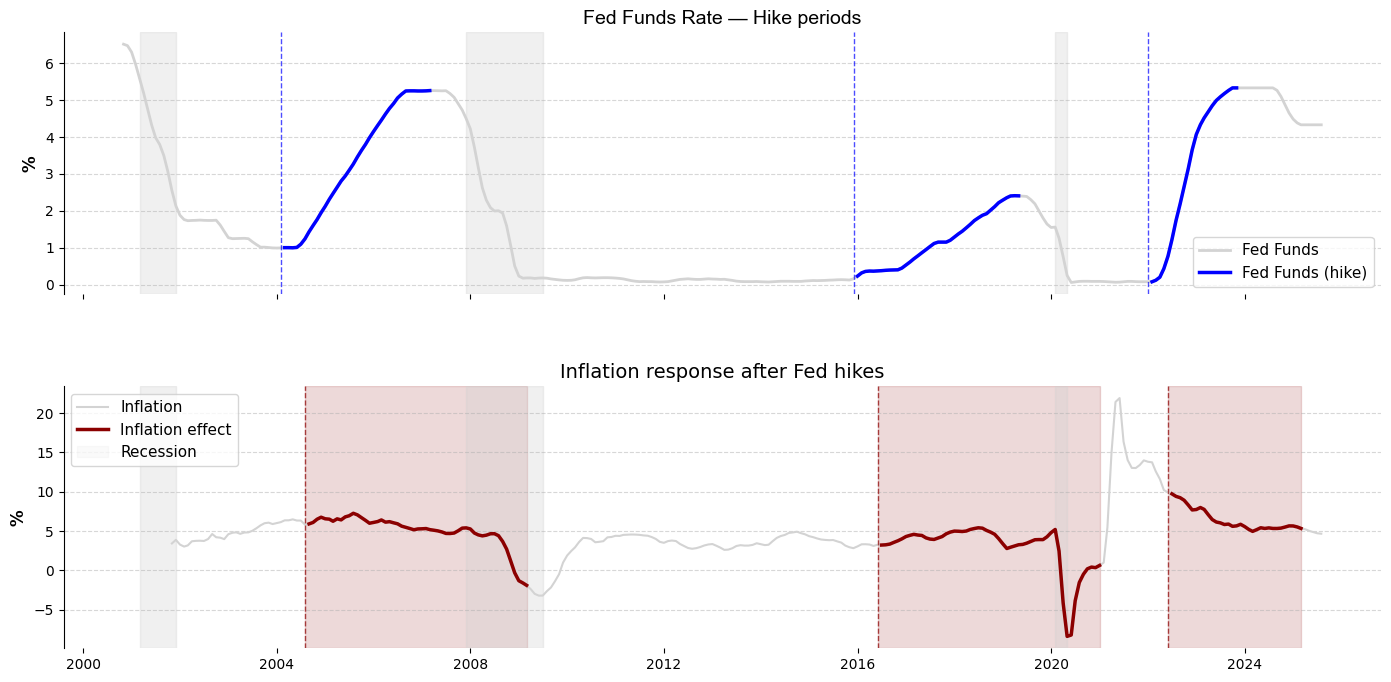

C:\Users\farho\AppData\Local\Temp\ipykernel_14052\698389314.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


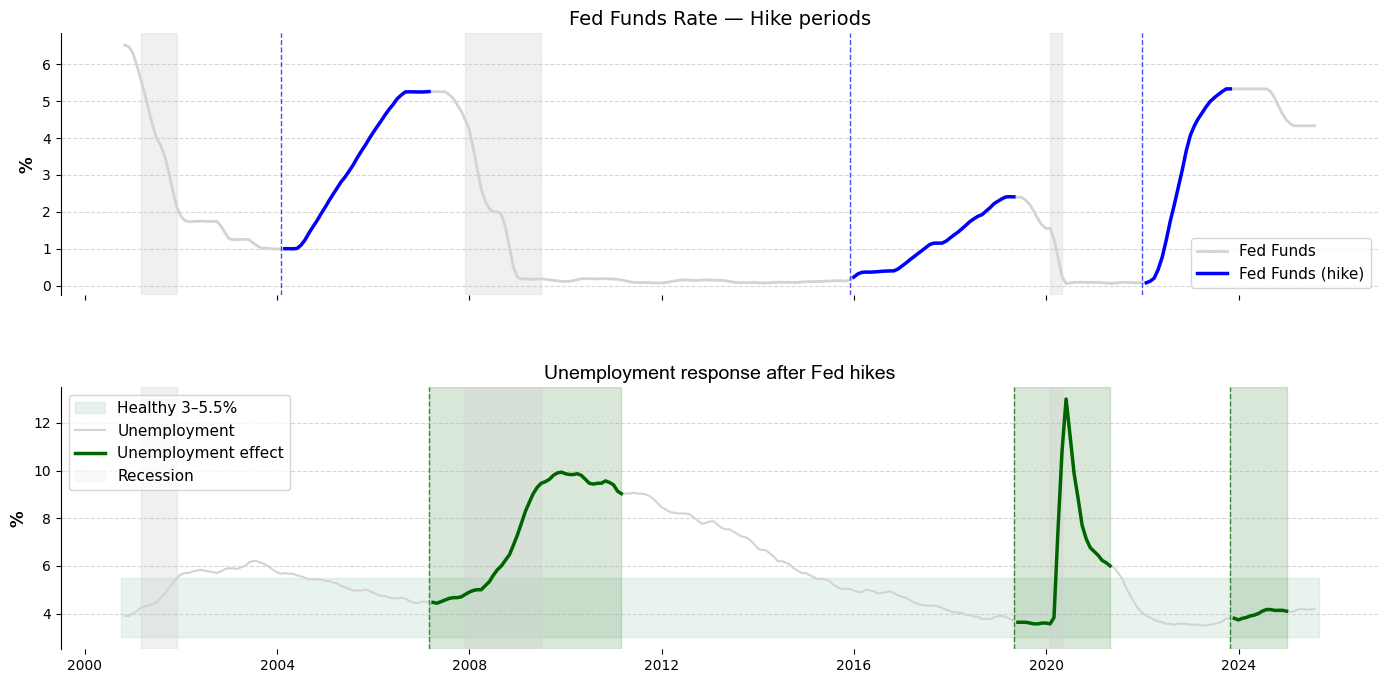

In [11]:
plot_outcome("Hike", hike_periods, hike_effects_inflation, hike_effects_unemployment)


### Fed Hikes and Unemployment Response

This chart shows unemployment with a **12-month lag** after hikes, shaded in green.  
The effect windows show unemployment tends to rise about a year after rate hikes.  

**Finding:**  
Rate hikes often lead to higher unemployment, as seen during the 2007–2009 financial crisis and post-2022 tightening.


# Now let's look at reactions after Fed Funds Rates Cuts

### Fed Cuts and Inflation Response

This chart shows:
- **Top panel**: Federal Funds Rate with **red segments** marking cut periods.  
- **Bottom panel**: Inflation (PCE YoY %) with shaded regions highlighting **lagged aftereffects** (lag = 6 months, effect = 18 months).  
- **Recessions** are shaded in gray.

**Findings:**  
- Inflation tends to **rise after rate cuts**, reflecting easier monetary conditions.  
- After the **2001 cuts**, inflation drifted upward modestly.  
- During the **2008–2009 financial crisis cuts**, inflation initially collapsed but then rebounded as policy stayed accommodative.  
- The **2020 pandemic cuts** partially were responsible for a sharp inflation surge starting in 2021–2022. Sharp inflation mainly was affected of production and supply chain issues during Covid and post-Covid periods  

This demonstrates how Fed cuts can stimulate demand, but also risk fueling higher inflation once the economy stabilizes.


C:\Users\farho\AppData\Local\Temp\ipykernel_14052\698389314.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


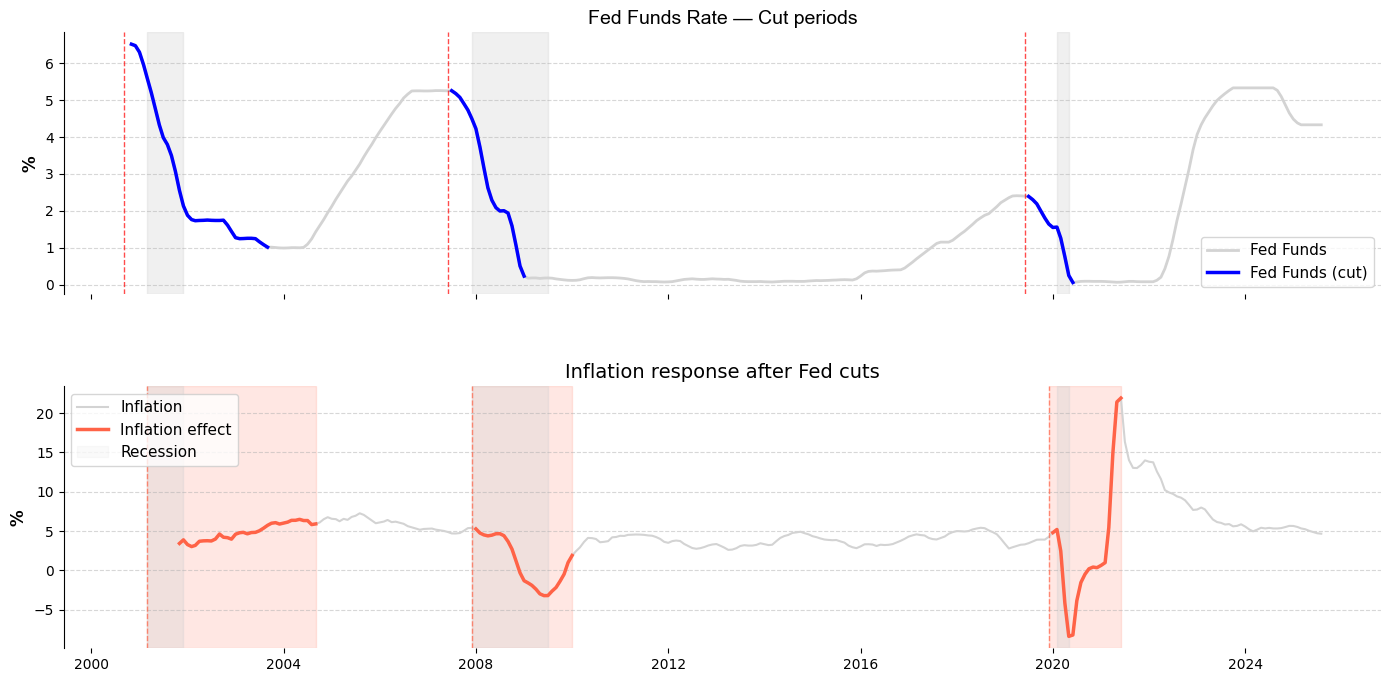

C:\Users\farho\AppData\Local\Temp\ipykernel_14052\698389314.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


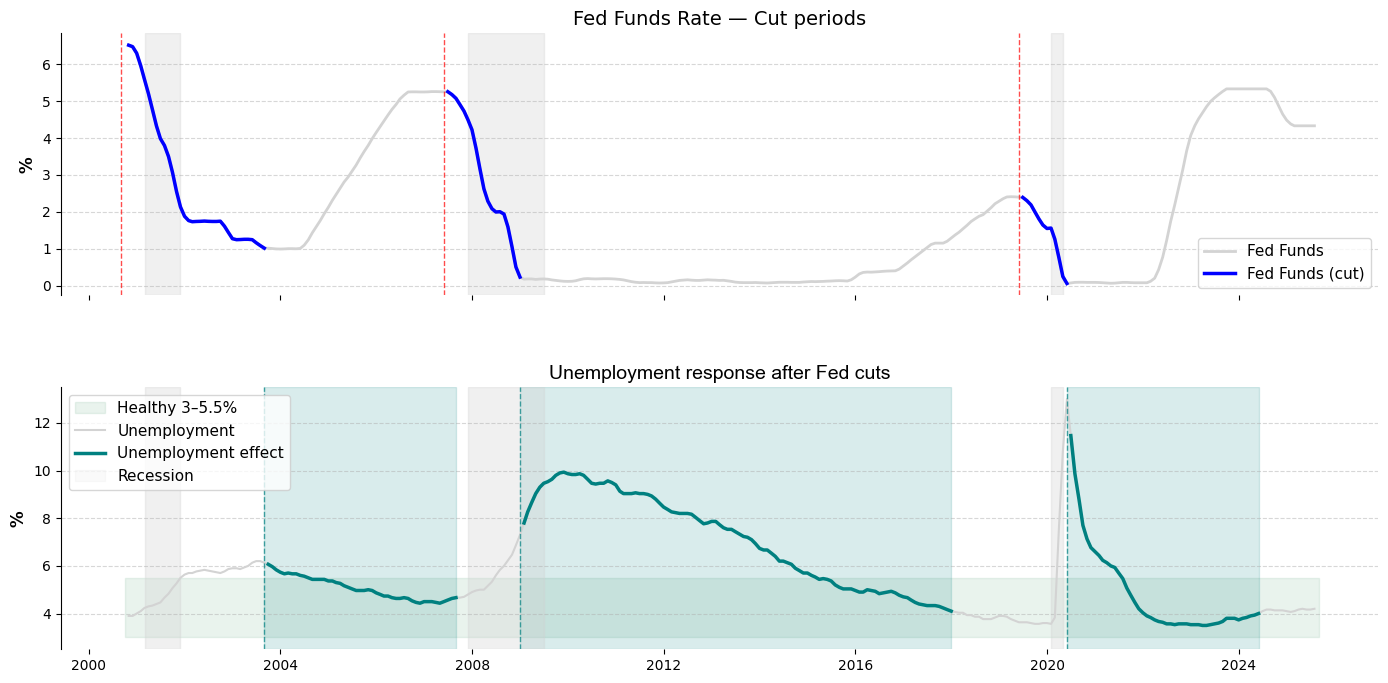

In [12]:
plot_outcome("Cut", cut_periods, cut_effects_inflation, cut_effects_unemployment)

### Fed Cuts and Unemployment Response

This chart above shows:
- **Top panel**: Federal Funds Rate with **red segments** marking cut periods.  
- **Bottom panel**: Unemployment Rate with shaded regions highlighting **lagged aftereffects** (lag = 12 months, effect periods varies).  
- Green shading indicates the Fed's "unemployment healthy range" of 3–5.5%.  
- **Recessions** are shaded in gray.

**Findings:**  
- Cuts are generally followed by **declines in unemployment**, though with a lag.  
- After the **2001 recession cuts**, unemployment gradually improved through the mid-2000s.  
- During the **2008–2009 crisis cuts**, unemployment spiked first, then stabilized and declined by 2010–2011.  
- The **2020 pandemic cuts** helped unemployment recover dramatically from the April 2020 peak.  

Overall, cuts appear effective in **supporting employment recovery**, though the improvement often arrives after a delay.  Cuts tend to boost inflation but help unemployment to recover.


In [13]:
def calc_from_effect_windows(df, windows, outcome, event_label):
    """Calculate average shift over manual effect windows."""
    series = df[outcome].copy()
    results = []
    for (start, end) in windows:
        # snap to nearest available index dates
        start = series.index[series.index.get_indexer([start], method="nearest")[0]]
        end   = series.index[series.index.get_indexer([end],   method="nearest")[0]]
        base_val = series.loc[start]
        end_val  = series.loc[end]
        shift = end_val - base_val
        results.append({
            "Outcome": outcome,
            "Event": event_label,
            "Label": f"{start.year}–{end.year}",   
            "Shift": shift
        })
    return pd.DataFrame(results)


# build data from manual effect periods
df_hike_infl = calc_from_effect_windows(df, manual_effects_hikes_inflation, "Inflation YoY (%)", "Hike")
df_hike_ur   = calc_from_effect_windows(df, manual_effects_hikes_unemployment, "Unemployment Rate (%)", "Hike")
df_cut_infl  = calc_from_effect_windows(df, manual_effects_cuts_inflation, "Inflation YoY (%)", "Cut")
df_cut_ur    = calc_from_effect_windows(df, manual_effects_cuts_unemployment, "Unemployment Rate (%)", "Cut")

# combine
summary_manual = pd.concat([df_hike_infl, df_hike_ur, df_cut_infl, df_cut_ur], ignore_index=True)

# clean labels
summary_manual["Outcome"] = summary_manual["Outcome"].replace({
    "Inflation YoY (%)": "Inflation",
    "Unemployment Rate (%)": "Unemployment"
})


In [14]:
def plot_event_faceted(event_label, color, summary_df):
    sub = summary_df[summary_df["Event"]==event_label].copy()
    outcomes = ["Inflation", "Unemployment"]

    fig, axes = plt.subplots(1, 2, figsize=(15,7), sharey=True)
    for i, outcome in enumerate(outcomes):
        ax = axes[i]
        sub2 = sub[sub["Outcome"]==outcome]
        x = np.arange(len(sub2))

        vals = sub2["Shift"].values
        labels = sub2["Label"].values

        # bars
        ax.bar(x, vals, color=color, alpha=0.85)

        ax.axhline(0, color="gray", lw=1)

        # background colors
        ax.set_facecolor("#ffe6e6" if outcome=="Inflation" else "#e6ffe6")

        # axis setup
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12, family="serif")
        ax.set_title(outcome, fontsize=16, fontweight="bold", family="Arial")
        if i == 0:
            ax.set_ylabel("Shift from starting point (%)", fontsize=13, family="Arial")

        # remove border lines
        for spine in ["top", "right", "left", "bottom"]:
            ax.spines[spine].set_visible(False)

        # annotations with years included
        for xi, (v, period) in enumerate(zip(vals, labels)):
            if not np.isnan(v):
                direction = "went up" if v > 0 else "went down"
                text = f"In {period}\n{direction} {abs(v):.1f}%"

                if abs(v) > 8:  
                    y_pos = v/2
                    va = "center"
                    color_txt = "white"
                else:
                    offset = 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
                    y_pos = v + offset if v > 0 else v - offset
                    va = "bottom" if v > 0 else "top"
                    color_txt = "black"

                ax.text(xi, y_pos, text,
                        ha="center", va=va,
                        fontsize=11, fontweight="bold",
                        family="Arial", color=color_txt)
        
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(ymin - 2, ymax + 2)   



    #title
    fig.suptitle(f"Impact of Fed Rate {event_label.upper()}S (after effect periods)",
                 fontsize=18, fontweight="bold", family="Arial", y=1.02)

    plt.tight_layout()
    plt.show()


### Bar Charts: Measured Effects Over Manual Windows

We measure inflation and unemployment shifts from the **start to end** of manually defined aftereffect windows:
- Labels (e.g., 2004–2009) indicate the window years.
- Bars show % change (relative to start).
- Annotations summarize direction and magnitude.

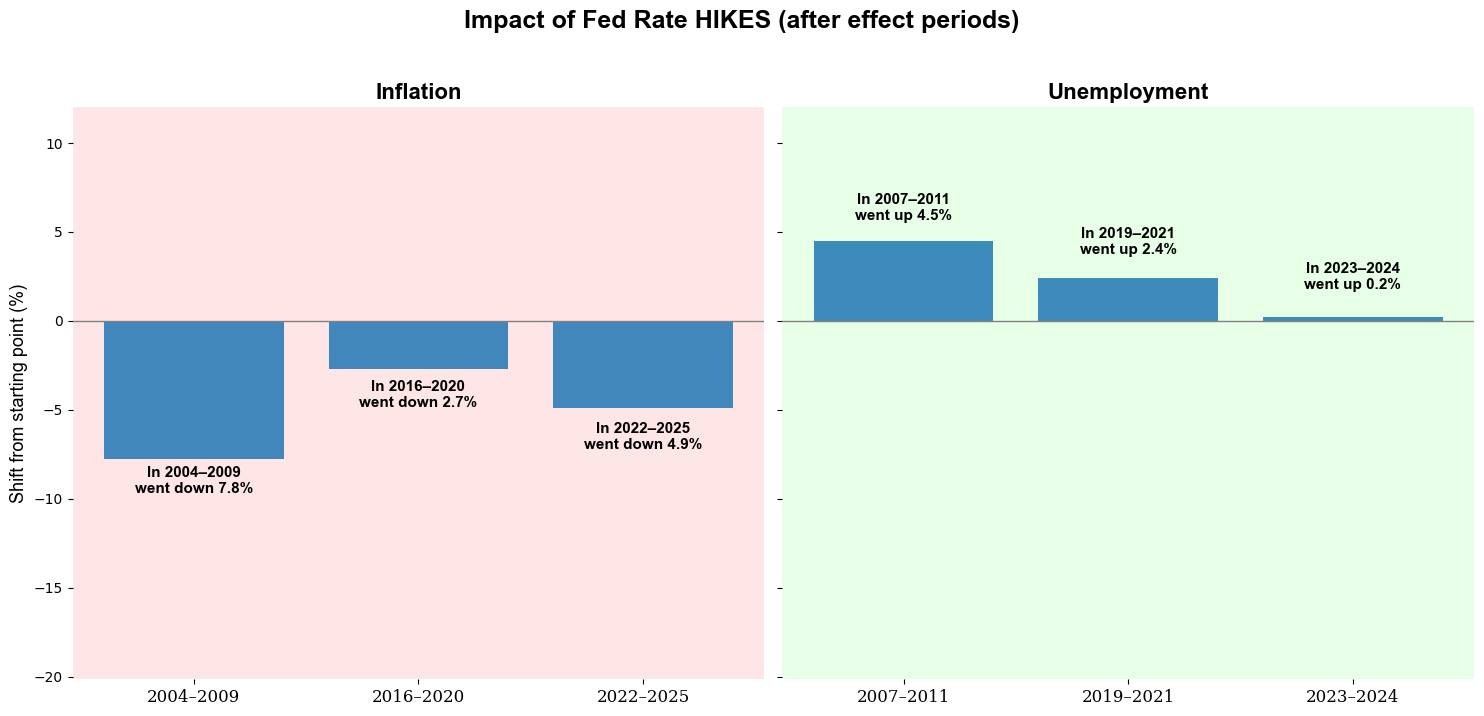

In [15]:

plot_event_faceted("Hike", "tab:blue", summary_manual)



**Findings:**
- After **hikes**, inflation typically fell (negative bars), while unemployment rose.



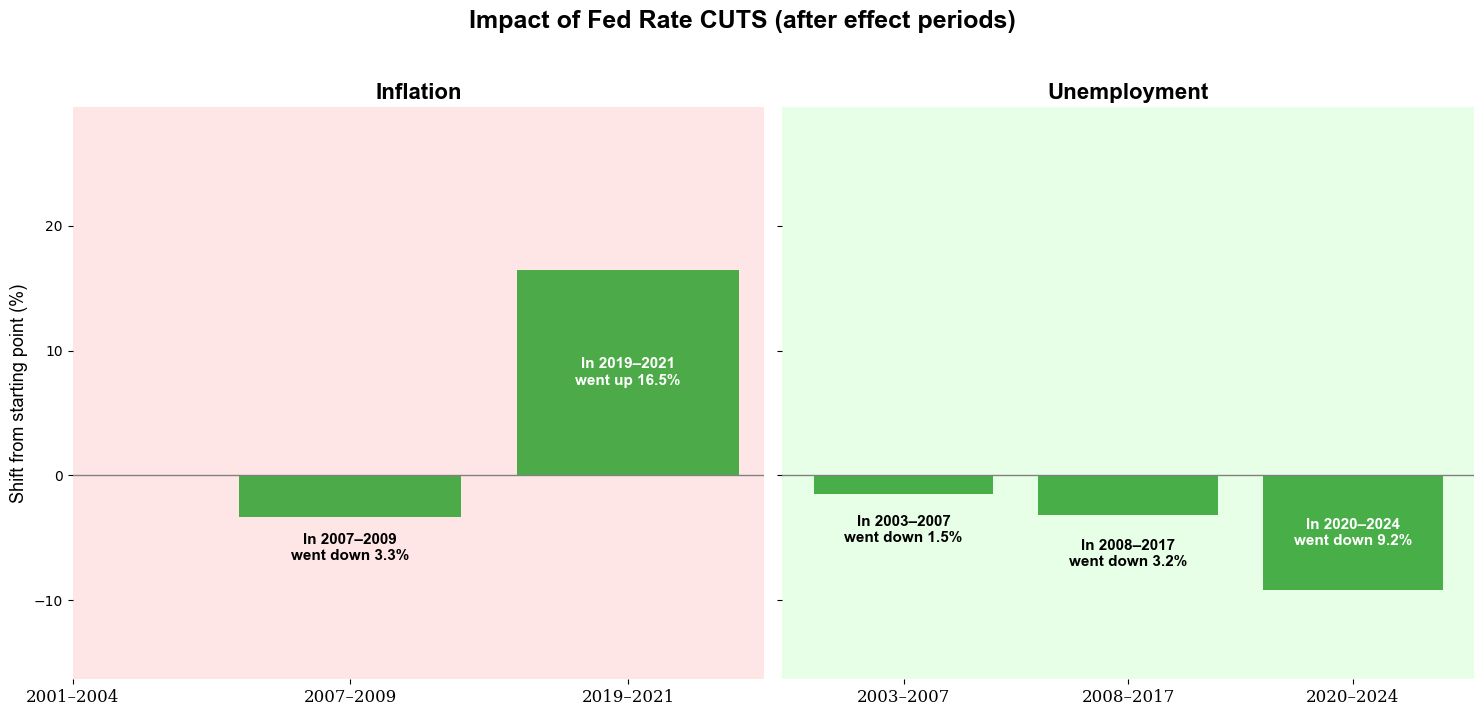

In [16]:
plot_event_faceted("Cut", "tab:green", summary_manual)

**Findings:**
- After **cuts**, inflation rose, while unemployment declined.
- These findings align with the Fed’s dual mandate: balancing price stability and employment.

In [17]:
def calc_avg_shift(series, windows):
    """Compute average change from start to end of effect windows."""
    shifts = []
    for start, end in windows:
        start_idx = series.index[series.index.get_indexer([start], method="nearest")[0]]
        end_idx   = series.index[series.index.get_indexer([end],   method="nearest")[0]]
        base_val = series.loc[start_idx]
        end_val  = series.loc[end_idx]
        shifts.append(end_val - base_val)
    return pd.Series(shifts).mean()

X = calc_avg_shift(df["Inflation YoY (%)"], manual_effects_hikes_inflation)   
Y = calc_avg_shift(df["Unemployment Rate (%)"], manual_effects_hikes_unemployment)     
Z = calc_avg_shift(df["Inflation YoY (%)"], manual_effects_cuts_inflation)    
W = calc_avg_shift(df["Unemployment Rate (%)"], manual_effects_cuts_unemployment)      

print("X (Hike → Inflation):", X)
print("Y (Hike → Unemployment):", Y)
print("Z (Cut → Inflation):", Z)
print("W (Cut → Unemployment):", W)



X (Hike → Inflation): -5.119889081672864
Y (Hike → Unemployment): 2.3666666666666667
Z (Cut → Inflation): 6.572997612719067
W (Cut → Unemployment): -4.633333333333333


# Summary & Conclusions

These analysis show clear trade-offs between inflation and unemployment following Fed actions:

| Fed Rate Event | Outcome in      | Average Shift | Direction |
|-------|--------------|-----------|-----------|
| Hike  | Inflation    | - 5.12%       | Down      |
| Hike  | Unemployment | + 2.37%       | Up        |
| Cut   | Inflation    | + 6.57%       | Up        |
| Cut   | Unemployment | - 4.63%       | Down      |

**Key Takeaways:**
- Hikes are effective in reducing inflation but come with the cost of increasing unemployment.  
- Cuts can ease unemployment rates but often causes rises in inflationion .  
- The patterns are consistent across multiple historical reseccion cycles (2000s, Global Financial Crisis of 2007–2009, COVID, post-COVID).  

This analysis demonstrates the **lagged and asymmetric nature** of monetary policy:  
effects on inflation appear sooner (6 months), while effects on unemployment take longer (12+ months).
